In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave
from tqdm import tqdm

import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam,Adagrad
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from math import sqrt
from keras.callbacks import History 
from keras.optimizers import Adam, SGD
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, merge
from keras.layers import Activation, Dropout, Flatten, Dense,Input
from keras.layers import BatchNormalization
from keras.models import Model
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
import keras.backend as K
from math import sqrt
from keras.callbacks import History 
import gc

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataPath = '/home/rsk/Documents/UPenn/DymaxionLabs/SlumPatches/Patches'

In [3]:
def read_img(filepath, size,grayscale=False):
    
    if grayscale:
        img = image.load_img((filepath), target_size=size,grayscale=True)
        img = image.img_to_array(img,data_format='channels_last')
    else:
        img = image.load_img((filepath), target_size=size)
        img = image.img_to_array(img,data_format='channels_last')
    return img

In [4]:
%run '/home/rsk/Documents/UPenn/DymaxionLabs/Modeling/util.py'


In [5]:
imgSize = (256,256)
batchSize = 6

In [6]:
from keras.metrics import binary_crossentropy

In [7]:
smooth = 1.

def dice_coef(y_true, y_pred):
#     y_true_f = K.greater(K.flatten(y_true),0.5)
#     y_pred_f = K.greater(K.flatten(y_pred),0.5)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return binary_crossentropy(y_true,y_pred) + 0.0*(1.-dice_coef(y_true, y_pred))

### Generator

In [19]:
class Generator(keras.utils.Sequence):
    
    def __init__(self,path,folderList,invertMask = True):
        
        self.path = path
        self.folderList = folderList
        self.invertMask = invertMask
        
        fileList = []
        
        for i in range(len(folderList)):
            files = os.listdir(os.path.join(path,folderList[i]))
            fileList += [os.path.join(path,folderList[i],x) for x in files]
            
        self.imgList = [x for x in fileList if "img" in x]  #Keeping only the RGB map images
        
        
    def __len__(self):
        
        return 30
    
    def __getitem__(self,index):
        
        pairs, targets = self.getBatch(batch_size)
        
        return pairs, targets
        

     
        

    def getBatch(self,batchSize):
              
        imgs=[]
        masks=[]
        
        selections = np.random.choice(len(self.imgList),batchSize,replace=False)
        
        for i in range(batchSize):
            
            img = read_img(self.imgList[selections[i]],imgSize)
            
            maskFileName = self.imgList[selections[i]].replace("img","mask")
            
            mask = read_img(maskFileName,imgSize,grayscale=True)
            mask = mask/255.0
            
            imgs.append(img/255.0)
            
            if self.invertMask:
                mask = invertMask(mask)
                
            
            masks.append(mask.reshape(mask.shape[0],mask.shape[1],1))
        
        imgs = np.array(imgs)
        masks = np.array(masks)
            
          

        return( imgs, masks)
    
    def on_epoch_end(self):
        'Updates to be done after each epoch'
        a = 5
        
        
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.getBatch(batch_size)
            yield (pairs, targets)

### Model

#### Model 1

In [176]:

inputs = Input((256,256,3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',dice_coef])
# model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef])
    

    

/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: U

#### Model 2

In [189]:

inputs = Input((256,256,3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

# model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef,'accuracy'])
    

    

/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: U

#### Model 3

In [20]:

inputs = Input((256,256,3))
bn1 = BatchNormalization()(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

bn2 = BatchNormalization()(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

bn3 = BatchNormalization()(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

bn4 = BatchNormalization()(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

# model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef,'accuracy'])
    

    

/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:37: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:43: U

#### Model run

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [11]:
trainFolders = ['17JUN10140042_P003_R2C2','16AUG22134016_P004_R1C1','17JAN07134545_P002_R2C1']
testFolders = ['17JUN10140042_P003_R1C1']

In [21]:
gen = Generator(dataPath,trainFolders,invertMask=False)
testGen  = Generator(dataPath,testFolders,invertMask = False)

In [22]:
epochs=5

In [33]:
model.fit_generator(gen.generate(5),epochs=epochs,verbose=1,validation_data=testGen.generate(5),validation_steps = 5,steps_per_epoch = 100)

Epoch 1/5
100/100 [==============================] - 76s 765ms/step - loss: 0.1683 - dice_coef: 0.9694 - acc: 0.9261 - val_loss: 1.6288 - val_dice_coef: 0.8825 - val_acc: 0.7931
Epoch 2/5
100/100 [==============================] - 76s 763ms/step - loss: 0.1421 - dice_coef: 0.9747 - acc: 0.9381 - val_loss: 0.6032 - val_dice_coef: 0.9328 - val_acc: 0.8598
Epoch 3/5
100/100 [==============================] - 80s 795ms/step - loss: 0.1233 - dice_coef: 0.9783 - acc: 0.9467 - val_loss: 1.6460 - val_dice_coef: 0.8694 - val_acc: 0.7636
Epoch 4/5
100/100 [==============================] - 78s 780ms/step - loss: 0.1046 - dice_coef: 0.9817 - acc: 0.9533 - val_loss: 0.8594 - val_dice_coef: 0.9066 - val_acc: 0.8179
Epoch 5/5
100/100 [==============================] - 70s 701ms/step - loss: 0.0829 - dice_coef: 0.9859 - acc: 0.9629 - val_loss: 1.3055 - val_dice_coef: 0.8907 - val_acc: 0.7950


In [51]:
model.evaluate_generator(train_generator)

[0.08571741580963135, 0.9142825841903687]

In [52]:
pred = model.predict_generator(train_generator)

In [43]:
testx = testGen.generate(1)

In [49]:
testGen.generate(1).next()[1].shape

(1, 256, 256, 1)

In [24]:
def evaluateImage(generator):
    
    img,mask = generator.generate(1).next()
    
    pred = model.predict(img)
    scores = model.evaluate(img,mask)
    print("Model scores : {}".format(scores))
    print("Predicted entropy : {}".format(getCrossEntropy(mask=mask,pred=pred)))
    print("Predicted mask : {}".format(getDice(mask,pred)))
    
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.imshow(pred.reshape(256,256),cmap='gray')
    
    plt.subplot(132)
    plt.imshow(mask.reshape(256,256),cmap='gray')
    
    plt.subplot(133)
    plt.imshow(img[:,:,:,2].reshape(256,256))
    
    return(pred,mask,img)
    
    
    

1/1 [==============================] - 0s 49ms/step
Model scores : [0.11222870647907257, 0.9753844141960144, 0.942962646484375]
Predicted entropy : 0.111418575171
Predicted mask : 0.975384387817


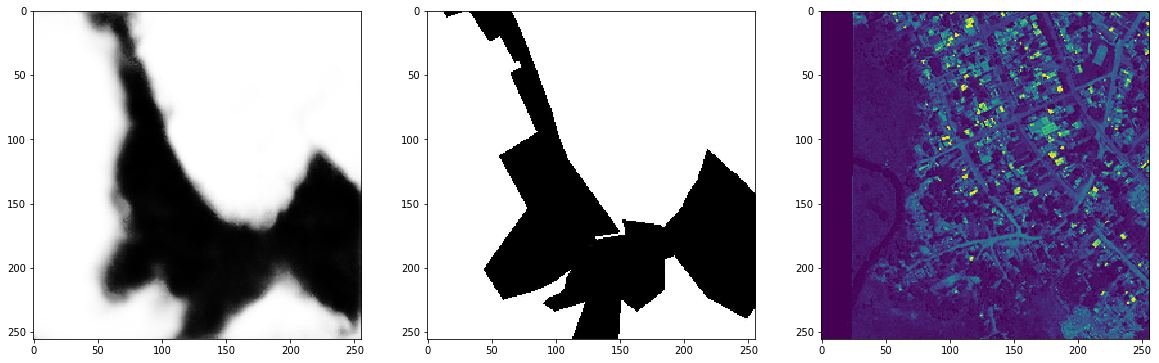

In [37]:
pred,mask,img = evaluateImage(gen)

In [27]:
binaryMask = toBinary(mask)
pd.Series(binaryMask.reshape(-1)).value_counts()

1.0    57542
0.0     7994
dtype: int64

In [166]:
pd.Series(binaryMask.reshape(-1)).value_counts()

1.0    61846
0.0     3690
dtype: int64

In [167]:
binaryPred = toBinary(pred)
pd.Series(binaryPred.reshape(-1)).value_counts()

1.0    63269
0.0     2267
dtype: int64

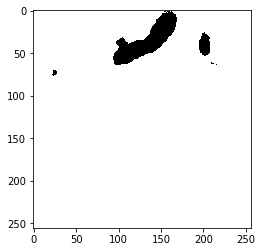

In [179]:
plt.imshow(binaryPred.reshape((256,256)),cmap='gray')

In [176]:
getDice(binaryMask,binaryPred)

0.9815930816202564

In [185]:
mask1 = invertMask(binaryMask)
pred1 = invertMask(binaryPred)

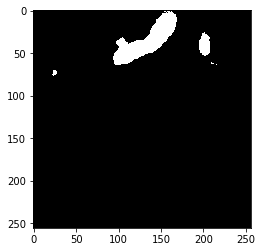

In [186]:
plt.imshow(pred1.reshape((256,256)),cmap='gray')

In [183]:
pd.Series(pred1.reshape(-1)).value_counts()

1.0    63269
0.0     2267
dtype: int64

In [187]:
getDice(mask1,pred1)

0.6134608929170863

In [56]:
img,mask = testGen.generate(1).next()
    
pred = model.predict(img)
scores = model.evaluate(img,mask)
print("Model scores : {}".format(scores))
print("Predicted entropy : {}".format(getCrossEntropy(mask=mask,pred=pred)))
print("Predicted mask : {}".format(getDice(mask,pred)))

1/1 [==============================] - 0s 49ms/step
Model scores : [0.16806411743164062, 0.8319358825683594]
Predicted entropy : 0.612231398025
Predicted mask : 0.831935861371


In [58]:
pd.Series(mask.reshape(-1)).value_counts()

1.000000    61864
0.000000     3460
0.980392       14
0.992157       13
0.015686       13
0.988235       11
0.984314       10
0.972549       10
0.976471        9
0.996078        9
0.047059        8
0.007843        7
0.011765        7
0.003922        6
0.023529        6
0.074510        5
0.058824        5
0.050980        5
0.031373        5
0.960784        4
0.027451        4
0.952941        4
0.945098        4
0.019608        4
0.054902        4
0.937255        4
0.956863        3
0.086275        3
0.043137        3
0.066667        2
0.882353        2
0.933333        2
0.929412        2
0.039216        2
0.925490        2
0.062745        2
0.964706        2
0.094118        2
0.078431        2
0.968627        2
0.082353        1
0.941176        1
0.921569        1
0.101961        1
0.949020        1
0.909804        1
0.105882        1
0.035294        1
0.090196        1
0.901961        1
dtype: int64

In [69]:
pd.Series(np.invert(mask).reshape(-1)).value_counts()

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [71]:
from PIL import ImageOps

In [72]:
ImageOps.invert(pred)

AttributeError: 'numpy.ndarray' object has no attribute 'mode'

### Testing

In [41]:
pred = model.predict(trainx[0:6])

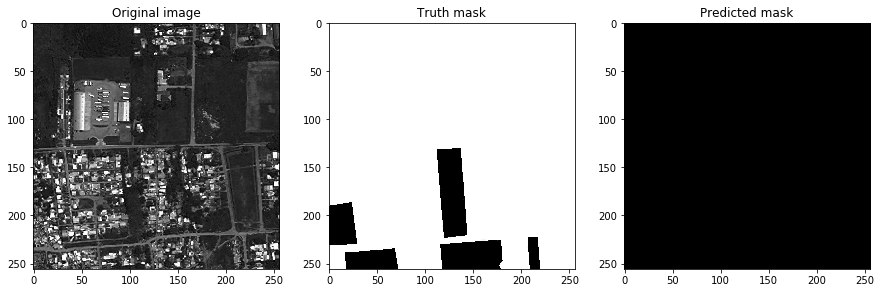

In [43]:
testImage = 5

plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title('Original image')
plt.imshow(trainx[testImage,:,:,0],cmap='gray')


plt.subplot(132)
plt.title('Truth mask')
plt.imshow(trainy[testImage,:,:,0],cmap='gray')

plt.subplot(133)
plt.title('Predicted mask')

plt.imshow(pred[testImage,:,:,0],cmap='gray')

In [44]:
y = pred[1,:,:,:]

In [45]:
np.min(y)

0.5123659

In [46]:
np.max(y)

0.5123659

In [63]:
getDice(trainy[1,:,:,:],toBinary(pred[1,:,:,:]))

0.8480257973556425

In [70]:
pd.Series(toBinary(pred[1,:,:,:] ).reshape( (256*256,)) ).value_counts()

1.0    65536
dtype: int64

In [68]:
toBinary(pred[1,:,:,:].reshape( (256*256,) )).reshape

(256, 256, 1)

In [ ]:
from keras.metrics import binary_accuracy, binary_crossentropy

In [97]:
folderList = os.listdir(dataPath)

In [98]:
imgList = [x for x in folderList if "img" in x]

In [110]:
selection = np.random.choice(len(imgList))
img = read_img(os.path.join(dataPath,imgList[selection]),imgSize)

mask = read_img(os.path.join(dataPath,imgList[selection].replace("img","mask")),imgSize,True)

In [111]:
img = img.reshape((1,256,256,3))
mask = mask.reshape((1,256,256,1))

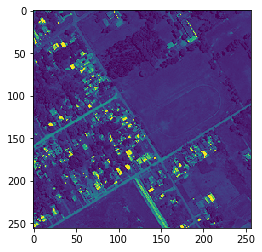

In [141]:
plt.imshow(img[:,:,1])

In [143]:
np.max(img)

255.0

In [144]:
from sklearn.metrics import accuracy_score,f1_score

In [130]:
imgs=[]
masks=[]

for i in range(5):
    
    img = read_img(os.path.join(dataPath,imgList[i]),imgSize)

    mask = read_img(os.path.join(dataPath,imgList[i].replace("img","mask")),imgSize,True)
    
    imgs.append(img/255.0)
    masks.append(mask.reshape((256,256,1))/255.0)
    

imgs = np.array(imgs)
masks = np.array(masks)
    
    

In [131]:
preds = model.predict(imgs)

In [151]:
def accuracy(pred,mask):
    
    correctPred =0.0
    
    pred = list(pred.reshape(256*256,))
    mask = list(mask.reshape(256*256,))
    pred = [1.0 if x>=0.5 else 0.0 for x in pred]
    
    for i in range(256*256):
        if pred[i]==mask[i]:
            correctPred += 1
    
    return(correctPred/(256*256))
        
        

In [153]:
accuracy(preds[1,:,:,:],masks[1,:,:,:])

0.8751983642578125

In [165]:
def scorePrint(pred,mask):
    
    acc = accuracy(pred,mask)
    print(acc)
    
    pred = toBinary(pred)
    print(np.min(pred))
    print(np.max(pred))
    plt.subplot(121)
    plt.imshow(pred.reshape(256,256))
    
    print(np.min(mask))
    print(np.max(mask))
    plt.subplot(122)
    plt.imshow(mask.reshape(256,256))
    

In [61]:
def toBinary(pred, threshold=0.5):
    
    pred = list(pred.reshape(256*256,))
    pred = np.array([1.0 if x>=threshold else 0.0 for x in pred])
    pred = pred.reshape((256,256,1))
    
    return(pred)
        

0.875198364258
1.0
1.0
0.0
1.0


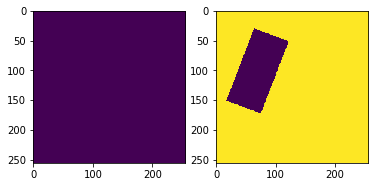

In [166]:
scorePrint(preds[1,:,:,:],masks[1,:,:,:])

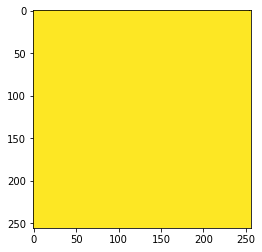

In [106]:
plt.imshow(pred.reshape((256,256)))

In [105]:
pred = pred*255.0

In [75]:
np.max(pred)

153.91814

In [114]:
pred

array([[[[0.5123421],
         [0.5123421],
         [0.5123421],
         ...,
         [0.5123421],
         [0.5123421],
         [0.5123421]],

        [[0.5123421],
         [0.5123421],
         [0.5123421],
         ...,
         [0.5123421],
         [0.5123421],
         [0.5123421]],

        [[0.5123421],
         [0.5123421],
         [0.5123421],
         ...,
         [0.5123421],
         [0.5123421],
         [0.5123421]],

        ...,

        [[0.5123421],
         [0.5123421],
         [0.5123421],
         ...,
         [0.5123421],
         [0.5123421],
         [0.5123421]],

        [[0.5123421],
         [0.5123421],
         [0.5123421],
         ...,
         [0.5123421],
         [0.5123421],
         [0.5123421]],

        [[0.5123421],
         [0.5123421],
         [0.5123421],
         ...,
         [0.5123421],
         [0.5123421],
         [0.5123421]]]], dtype=float32)

In [124]:

np.max(pred)==np.min(pred)

True

In [120]:
np.min(mask)

0.0

In [121]:
np.max(mask)

255.0

In [125]:
np.min(pred)

0.5123421